In [9]:
import ujson as json
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from matplotlib import cm
import sklearn.cluster as clstr
import scipy.sparse as sp
plt.rcParams['figure.figsize'] = [10, 10]
import seaborn as sb
import pandas as pd
import itertools
from plot_pose import *
from process import *
from angles import *
from kmeans import *
from dbscan import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
ARTIC_NAMES = {'foot 1': 0,
               'foot 2': 1,
               'knee 1': 2,
               'knee 2': 3,
               'belly': 4,
               'elbow 1': 5,
               'elbow 2': 6,
               'hand 1': 7,
               'hand 2': 8,
               'eye 1': 9,
               'eye 2': 10,
               'shoulder 1': 11,
               'shoulder 2': 12}

def cover_files():
    positions = []
    grottoes = []
    files = []
    for file_name in ("Apsaras3.json", "2_test_2.json"):
        print("Processing ", file_name)
        with open(file_name, 'r') as f:
            data = json.load(f)

            for apsara in data['apsaras']:
                grottoes.append(apsara['grottoe'])
                files.append(apsara['file'])
                access = apsara['positions']
                position = []
                for articulation in ARTIC_NAMES.keys():
                    position.append(access[articulation])
                positions.append(position)
    for file_name in ("1_test.json",
                      "1_train.json",
                      "2_train.json",
                      "2_test.json"):
        print("Processing ", file_name)
        with open(file_name, 'r') as f:
            data = json.load(f)
            for apsara in data:
                access = apsara["apsaras"]
                files.append(access["file"])
                grottoes.append(access["grottoe"])
                access = access["positions"]
                position = []
                for articulation in ARTIC_NAMES.keys():
                    position.append(access[articulation])
                positions.append(position)
    return np.array(positions)
positions = cover_files()

Processing  Apsaras3.json
Processing  2_test_2.json
Processing  1_test.json
Processing  1_train.json
Processing  2_train.json
Processing  2_test.json


In [11]:
positions.shape

(557, 13, 2)

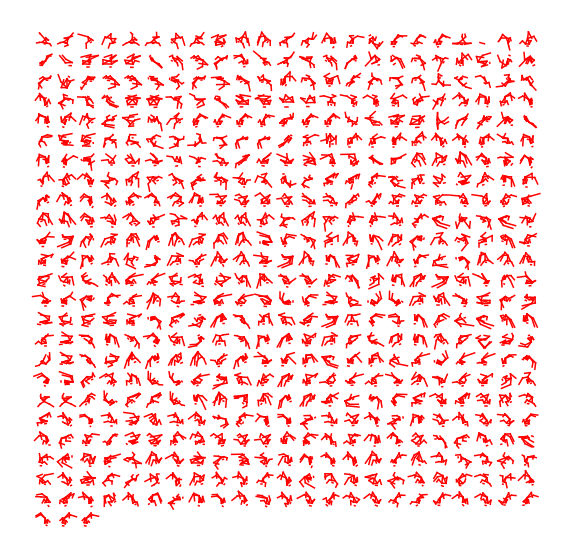

In [12]:
plot_all(preprocess(positions))

## Kmeans on the raw poses

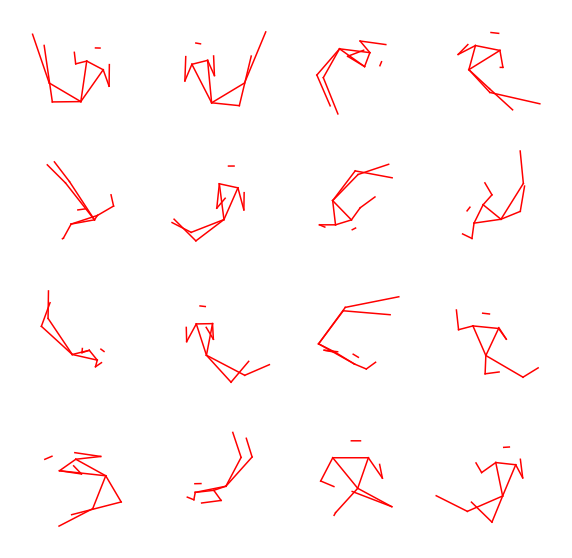

In [13]:
km = prepare_kmeans(positions, 16)
centers = km.cluster_centers_
plot_all(centers.reshape(centers.shape[0], -1, 2))

## Kmeans on the angles

### Knielauf

In [14]:
agls = get_angles(remove_nans(preprocess(positions)))

In [15]:
agls_knees = agls[:, :2]
agls_knees.shape

(527, 2)

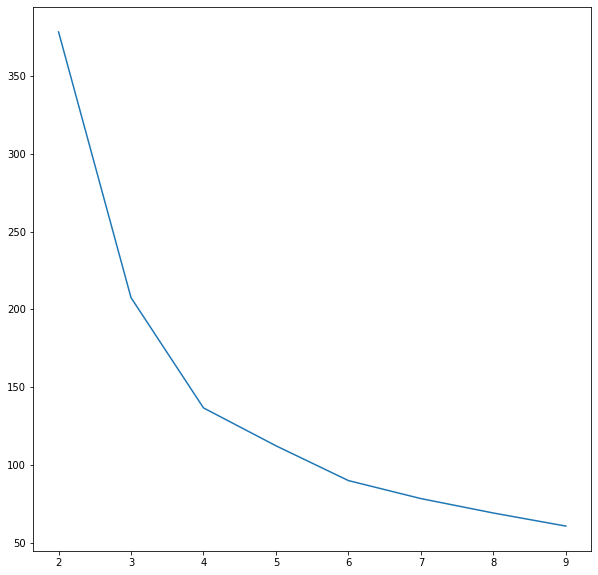

In [17]:
choose_km(agls_knees, n_max=10)

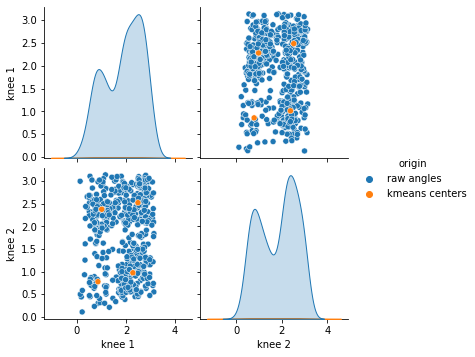

In [18]:
analyse_agls(agls_knees, n_clusters=4)
pass

### Elongated arms

In [19]:
agls_arms = agls[:, 2:]
agls_arms.shape

(527, 4)

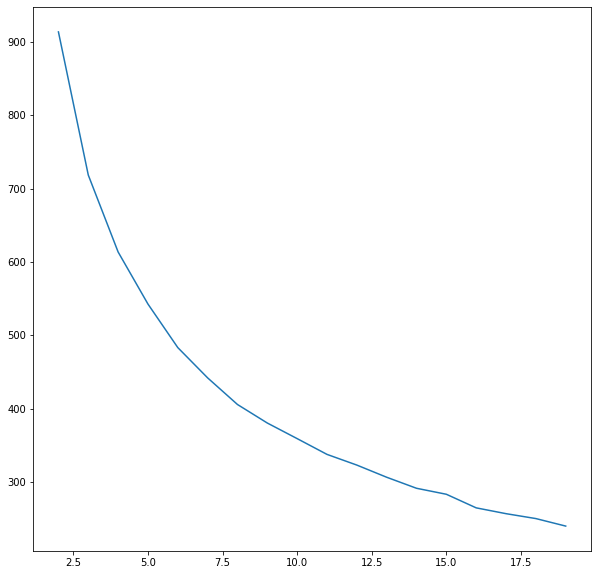

In [20]:
choose_km(agls_arms, n_max=20, names=["arm 1", "arm 2", "shoulder 1", "shoulder 2"])

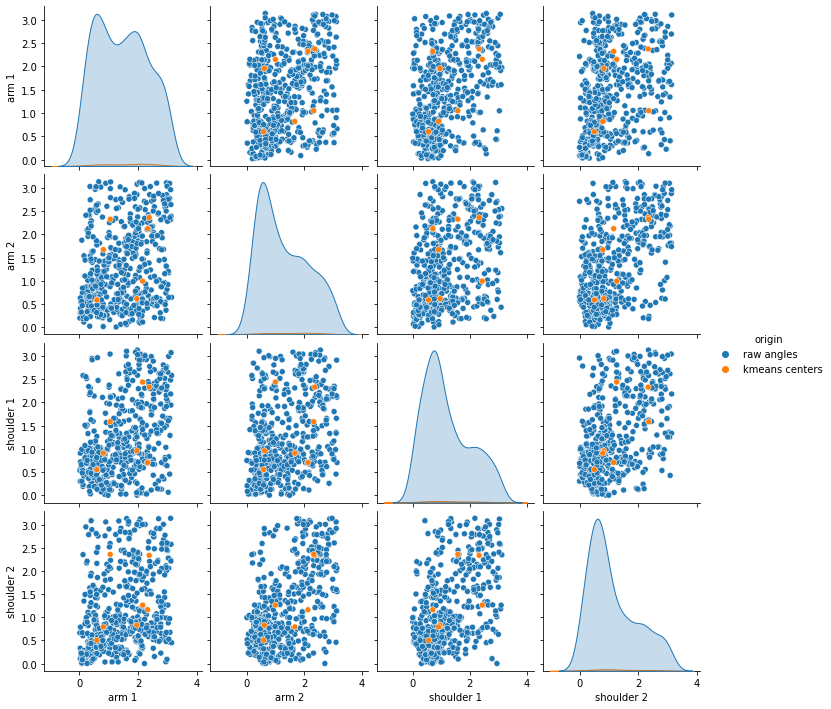

In [21]:
analyse_agls(agls_arms, n_clusters=7, names=["arm 1", "arm 2", "shoulder 1", "shoulder 2"])
pass

## DBSCAN

In [22]:
colors = {-1: 'black',
          0: 'r',
          1: 'g',
          2: 'b',
          3: 'm',
          4: 'y',
          5: 'b', 
          6: 'brown',
          7: 'crimson',
          8: 'pink',
          9: 'gold',
          10: 'navy',
          11: 'violet'}

### Knielauf

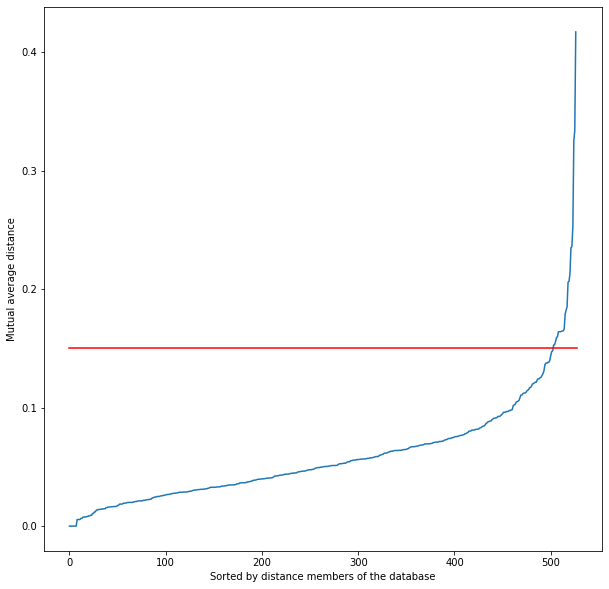

In [23]:
dbscan_choose_eps(agls_knees, .15)

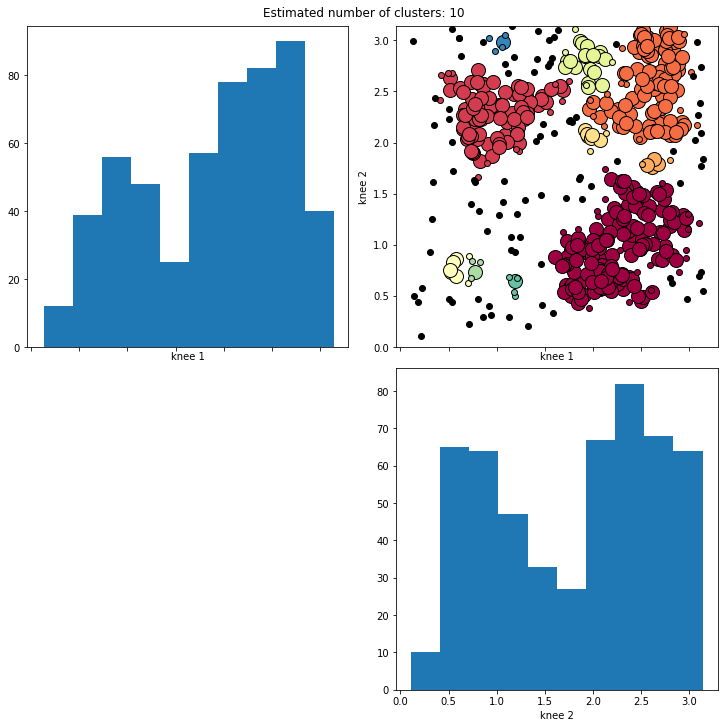

In [27]:
knee_labels_dbs, _ = do_dbscan(agls_knees, .15, names=["knee 1", "knee 2"])

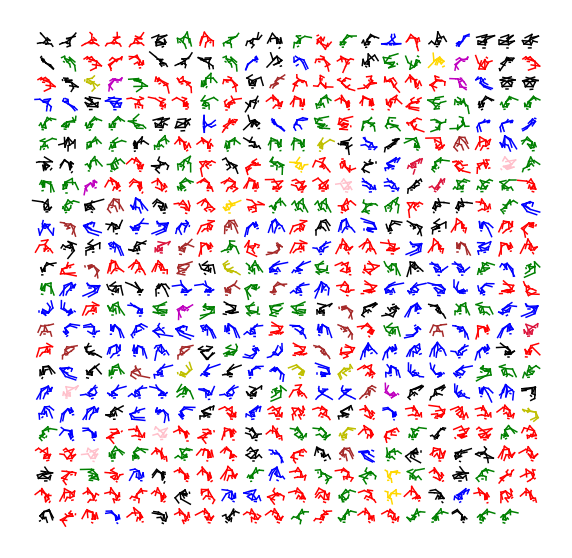

In [28]:
plot_all(remove_nans(preprocess(positions)),
         colors=lambda lbl: colors[lbl],
         labels=knee_labels_dbs)

In [30]:
cluster_num_knee = []
for i in range(-1,10):
    cluster_num_knee.append((np.array(knee_labels_dbs) == i).sum())
cluster_num_knee

### Elongated arms

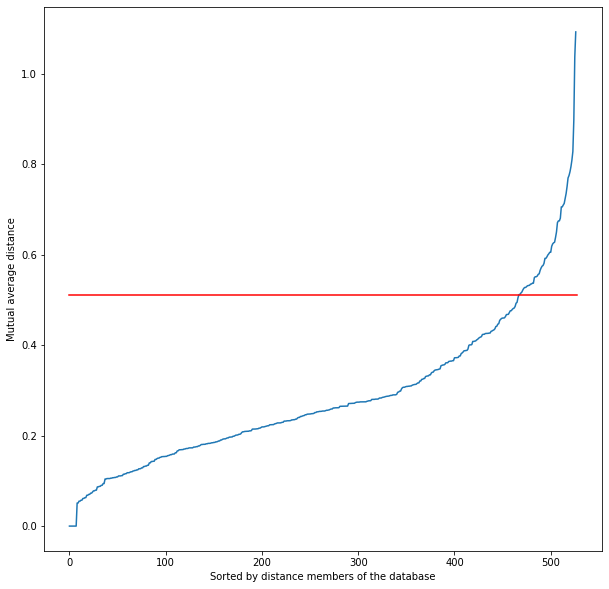

In [32]:
dbscan_choose_eps(agls_arms, .51)

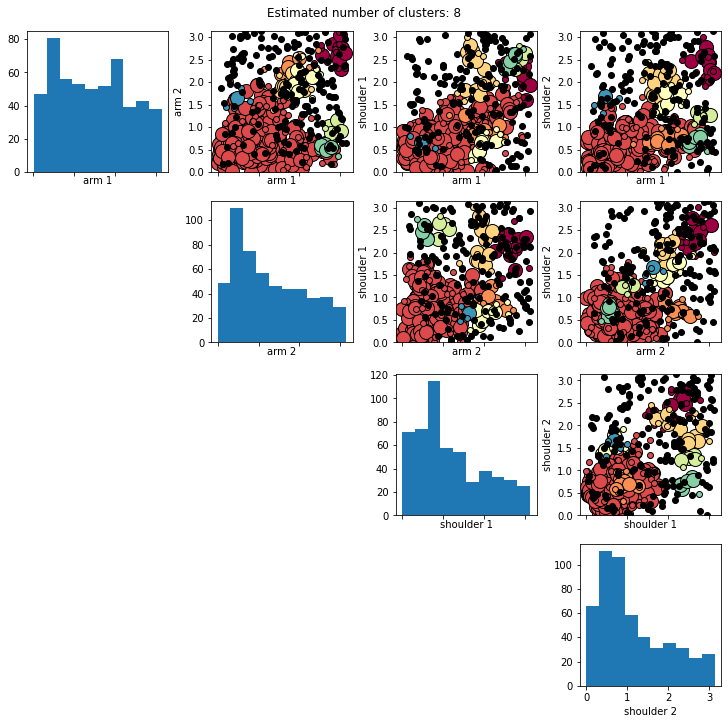

In [33]:
arms_labels_dbs, _ = do_dbscan(agls_arms, .51, names=["arm 1", "arm 2", "shoulder 1", "shoulder 2"])

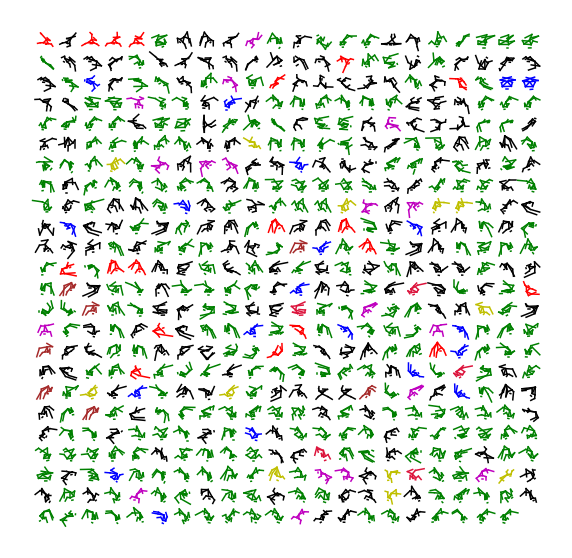

In [34]:
plot_all(remove_nans(preprocess(positions)),
         colors=lambda lbl: colors[lbl],
         labels=arms_labels_dbs)

In [35]:
cluster_num_arm = []
for i in range(-1,8):
    cluster_num_arm.append((np.array(knee_labels_dbs) == i).sum())
cluster_num_arm

[91, 164, 100, 115, 6, 8, 7, 22, 4]